In [32]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

In [34]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [35]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# 1) Load and basic cleaning

In [36]:
df = pd.read_csv("dataset.csv")

# Standardize column names

In [37]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

In [38]:
# Expect columns like:
# ['gender','age','smoking','yellow_fingers','anxiety','peer_pressure',
#  'chronic_disease','fatigue','allergy','wheezing','alcohol_consuming',
#  'coughing','shortness_of_breath','swallowing_difficulty','chest_pain','lung_cancer']

# Strip string columns and standardize

In [39]:
if "gender" in df.columns:
    df["gender"] = df["gender"].astype(str).str.strip().str.upper()
    df["gender"] = df["gender"].map({"M": 1, "F": 0})

In [40]:
# Map target YES/NO -> 1/0
if "lung_cancer" in df.columns:
    df["lung_cancer"] = df["lung_cancer"].astype(str).str.strip().str.upper().map({"YES": 1, "NO": 0})

In [41]:
# Ensure AGE numeric
if "age" in df.columns:
    df["age"] = pd.to_numeric(df["age"], errors="coerce")

In [42]:
# Convert 1/2-encoded columns to 0/1 by subtracting 1 (keeps order, model learns semantics)
binary_like_cols = []
for col in df.columns:
    if col in ["age", "gender", "lung_cancer"]:
        continue

In [43]:
# Check if column is numeric-like and uses 1/2
if pd.api.types.is_numeric_dtype(df[col]):
        unique_vals = set(df[col].dropna().unique().tolist())
        if unique_vals.issubset({1, 2}):
            binary_like_cols.append(col)
else:
        # Try converting to numeric and re-check
        coerced = pd.to_numeric(df[col], errors="coerce")
        unique_vals = set(coerced.dropna().unique().tolist())
        if unique_vals.issubset({1, 2}):
            df[col] = coerced
            binary_like_cols.append(col)

In [44]:
# Apply 1/2 -> 0/1 transform
for col in binary_like_cols:
    df[col] = df[col].astype(float) - 1.0

# Drop exact duplicates

In [45]:
before = len(df)
df = df.drop_duplicates()
after = len(df)
print(f"Dropped duplicates: {before - after}") #four duplicate are drop

Dropped duplicates: 2


# 2) Missing values handling

In [46]:
# Let imputer handle missing values later; but print missing summary
print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

Missing values per column:
gender                   0
age                      0
smoking                  0
yellow_fingers           0
anxiety                  0
peer_pressure            0
chronic_disease          0
fatigue                  0
allergy                  0
wheezing                 0
alcohol_consuming        0
coughing                 0
shortness_of_breath      0
swallowing_difficulty    0
chest_pain               0
lung_cancer              0
dtype: int64


# 3) EDA and Visualizations

In [47]:
os.makedirs("figures", exist_ok=True)

In [48]:
# If the "lung_cancer" column exists in your DataFrame before plotting
print("lung_cancer" in df.columns)


True


In [49]:
# non-null values does the "lung_cancer" column
print(df["lung_cancer"].notna().sum())
print(df["lung_cancer"].value_counts(dropna=False))


2998
lung_cancer
1    1517
0    1481
Name: count, dtype: int64


In [50]:
 # data filtering or cleaning step before plotting removed all rows or the entire target column data by mistake
print(df.head())
print(df.shape)


   gender  age  smoking  yellow_fingers  anxiety  peer_pressure  \
0       1   65        1               1        1              2   
1       0   55        1               2        2              1   
2       0   78        2               2        1              1   
3       1   60        2               1        1              1   
4       0   80        1               1        2              1   

   chronic_disease  fatigue  allergy  wheezing  alcohol_consuming  coughing  \
0                2        1        2         2                  2         2   
1                1        2        2         2                  1         1   
2                1        2        1         2                  1         1   
3                2        1        2         1                  1         2   
4                1        2        1         2                  1         1   

   shortness_of_breath  swallowing_difficulty  chest_pain  lung_cancer  
0                    2                      2    

In [51]:
print(df["lung_cancer"].dropna().shape[0])
print(df["lung_cancer"].unique())


2998
[0 1]


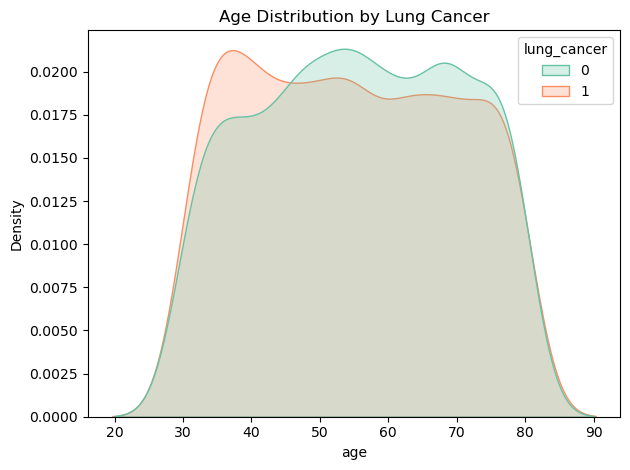

In [52]:
palette = "Set2"  # good for 2-8 categories

import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data=df, x="age", hue="lung_cancer", fill=True, common_norm=False, palette=palette)
plt.title("Age Distribution by Lung Cancer")
plt.tight_layout()
plt.show()


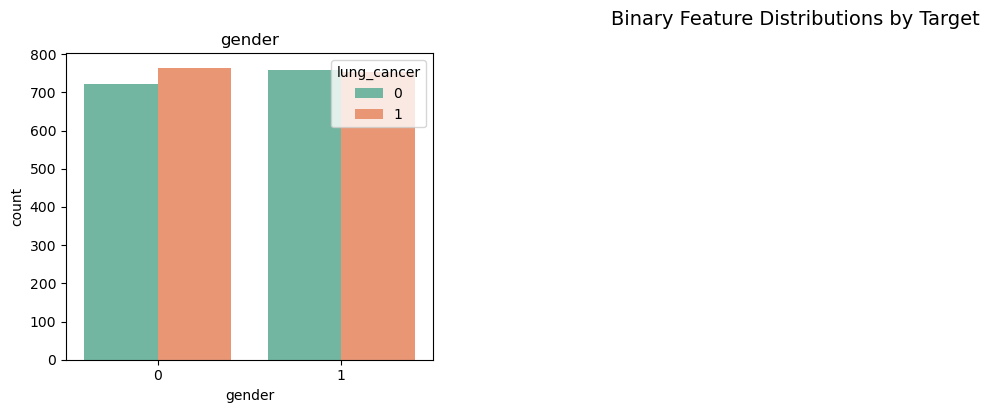

In [54]:
# Countplots of binary features vs target
if "lung_cancer" in df.columns:
    feature_cols = [c for c in df.columns if c not in ["lung_cancer"]]
    # Choose up to 12 binary-like features for compact plotting
    candidates = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c]) and set(df[c].dropna().unique()).issubset({0,1})]
    show_cols = candidates[:12]
    if show_cols:
        n = len(show_cols)
        rows = int(np.ceil(n/4))
        plt.figure(figsize=(16, 4*rows))
        for i, c in enumerate(show_cols, 1):
            plt.subplot(rows, 4, i)
            sns.countplot(data=df, x=c, hue="lung_cancer", palette="Set2")
            plt.title(c)
            plt.tight_layout()
        plt.suptitle("Binary Feature Distributions by Target", y=1.02, fontsize=14)
        plt.savefig("figures/feature_countplots.png", dpi=200, bbox_inches="tight")
        plt.show()

# 4) Train/Validation Split

In [55]:
target = "lung_cancer"
assert target in df.columns, "Target 'lung_cancer' not found."

X = df.drop(columns=[target])
y = df[target].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5) Preprocessing pipeline

In [56]:
imputer = SimpleImputer(strategy="most_frequent")
scaler = MinMaxScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

feature_names = X.columns.tolist()

# 6) Baseline models

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

print("\n=== Baseline: Logistic Regression ===")
lr = LogisticRegression(max_iter=200, class_weight="balanced", random_state=42)
lr.fit(X_train_scaled, y_train)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
lr_pred = (lr_probs >= 0.5).astype(int)
print(classification_report(y_test, lr_pred, digits=4))
print("AUC:", roc_auc_score(y_test, lr_probs))

print("\n=== Baseline: RandomForest ===")
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, random_state=42, class_weight="balanced_subsample"
)
rf.fit(X_train_scaled, y_train)
rf_probs = rf.predict_proba(X_test_scaled)[:, 1]
rf_pred = (rf_probs >= 0.5).astype(int)
print(classification_report(y_test, rf_pred, digits=4))
print("AUC:", roc_auc_score(y_test, rf_probs))



=== Baseline: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.5103    0.5000    0.5051       296
           1     0.5226    0.5329    0.5277       304

    accuracy                         0.5167       600
   macro avg     0.5165    0.5164    0.5164       600
weighted avg     0.5165    0.5167    0.5166       600

AUC: 0.5097906294452347

=== Baseline: RandomForest ===
              precision    recall  f1-score   support

           0     0.5184    0.5236    0.5210       296
           1     0.5316    0.5263    0.5289       304

    accuracy                         0.5250       600
   macro avg     0.5250    0.5250    0.5250       600
weighted avg     0.5251    0.5250    0.5250       600

AUC: 0.5500644559032717


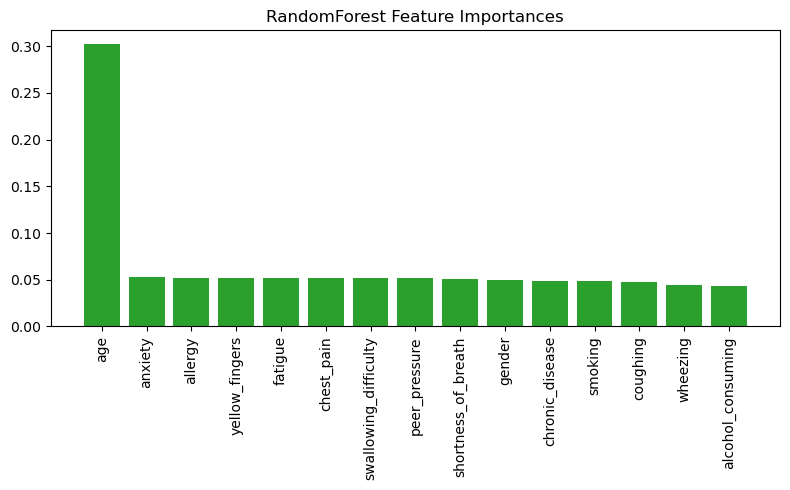

In [58]:
# RF feature importance plot
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances[idx], color="tab:green")
plt.xticks(range(len(importances)), [feature_names[i] for i in idx], rotation=90)
plt.title("RandomForest Feature Importances")
plt.tight_layout()
plt.savefig("figures/rf_feature_importance.png", dpi=200)
plt.show()

# 7) FusionNet-style Tabular Model

In [65]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ================== 1️⃣ Split Data ==================
target = "lung_cancer"
assert target in df.columns, "Target 'lung_cancer' not found."

X = df.drop(columns=[target])
y = df[target].astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================== 2️⃣ Scale Features ==================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================== 3️⃣ Convert to PyTorch Tensors ==================
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ================== 4️⃣ Create DataLoaders ==================
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

# ================== 5️⃣ Define Model ==================
class FusionNetTabular(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return self.net(x)

# ================== 6️⃣ Initialize Model, Loss, Optimizer ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionNetTabular(input_dim=X_train_t.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# ================== 7️⃣ Training Loop (with Early Stopping) ==================
best_val = np.inf
patience, patience_ctr = 10, 0
epochs = 100

for epoch in range(1, epochs + 1):
    # ===== TRAINING =====
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # ===== VALIDATION =====
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")

    # ===== EARLY STOPPING =====
    if val_loss < best_val - 1e-4:
        best_val = val_loss
        patience_ctr = 0
        torch.save(model.state_dict(), "fusionnet_tabular_best.pth")
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("⏹️ Early stopping triggered.")
            break

# ================== 8️⃣ Load Best Model ==================
model.load_state_dict(torch.load("fusionnet_tabular_best.pth", map_location=device))
print("✅ Best model loaded successfully.")


Epoch 001 | Train Loss = 0.7015 | Val Loss = 0.6934
Epoch 002 | Train Loss = 0.6948 | Val Loss = 0.6921
Epoch 003 | Train Loss = 0.6934 | Val Loss = 0.6913
Epoch 004 | Train Loss = 0.6902 | Val Loss = 0.6903
Epoch 005 | Train Loss = 0.6902 | Val Loss = 0.6898
Epoch 006 | Train Loss = 0.6879 | Val Loss = 0.6896
Epoch 007 | Train Loss = 0.6856 | Val Loss = 0.6890
Epoch 008 | Train Loss = 0.6828 | Val Loss = 0.6894
Epoch 009 | Train Loss = 0.6831 | Val Loss = 0.6885
Epoch 010 | Train Loss = 0.6782 | Val Loss = 0.6886
Epoch 011 | Train Loss = 0.6765 | Val Loss = 0.6893
Epoch 012 | Train Loss = 0.6766 | Val Loss = 0.6872
Epoch 013 | Train Loss = 0.6755 | Val Loss = 0.6853
Epoch 014 | Train Loss = 0.6718 | Val Loss = 0.6853
Epoch 015 | Train Loss = 0.6707 | Val Loss = 0.6856
Epoch 016 | Train Loss = 0.6695 | Val Loss = 0.6855
Epoch 017 | Train Loss = 0.6663 | Val Loss = 0.6852
Epoch 018 | Train Loss = 0.6649 | Val Loss = 0.6847
Epoch 019 | Train Loss = 0.6639 | Val Loss = 0.6856
Epoch 020 | 

# 8) Evaluation and plots

In [67]:
# ---------------------------
model.eval()
with torch.no_grad():
    Xte = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
    logits = model(Xte).cpu().numpy().ravel()
    probs = 1 / (1 + np.exp(-logits))
pred = (probs >= 0.5).astype(int)

print("\n=== FusionNet Tabular Results ===")
print(classification_report(y_test, pred, digits=4))
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1:", f1_score(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, probs))


=== FusionNet Tabular Results ===
              precision    recall  f1-score   support

           0     0.5579    0.5372    0.5473       296
           1     0.5651    0.5855    0.5751       304

    accuracy                         0.5617       600
   macro avg     0.5615    0.5613    0.5612       600
weighted avg     0.5615    0.5617    0.5614       600

Accuracy: 0.5616666666666666
Precision: 0.5650793650793651
Recall: 0.5855263157894737
F1: 0.5751211631663974
ROC AUC: 0.5918163229018492


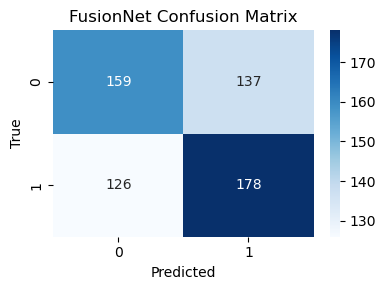

In [68]:
# Confusion matrix
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("FusionNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("figures/fusionnet_confusion_matrix.png", dpi=200)
plt.show()

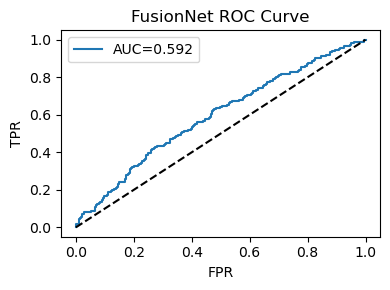


Artifacts saved in 'figures/' and model saved as 'fusionnet_tabular.pth'.


In [69]:
# ROC curve
fpr, tpr, thr = roc_curve(y_test, probs)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, probs):.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FusionNet ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("figures/fusionnet_roc.png", dpi=200)
plt.show()

print("\nArtifacts saved in 'figures/' and model saved as 'fusionnet_tabular.pth'.")